   time in min  (S)-3-OH-PAC    3-OH-BA  3-OH-BA-forged-1  3-OH-BA-forged-2  \
0          0.0      0.031101  10.891257         11.220156         10.713346   
1          0.5      1.883719   8.977816          9.623000          8.282877   
2          1.0      3.631862   7.306264          8.211833          6.484533   
3          1.5      5.212020   5.731909          6.441315          5.560666   
4          2.0      6.713972   4.349994          4.727210          4.168047   

   (R)-3-OH-PAC  (S)-3-OH-PAC.1  3-OH-BA.1  (R)-3-OH-PAC.1  
0           0.0        0.027853   0.059094             0.0  
1           0.0        0.077991   0.093238             0.0  
2           0.0        0.143958   0.114549             0.0  
3           0.0        0.143394   0.131286             0.0  
4           0.0        0.240008   0.170337             0.0  
Index(['time in min', '(S)-3-OH-PAC', '3-OH-BA', '3-OH-BA-forged-1',
       '3-OH-BA-forged-2', '(R)-3-OH-PAC', '(S)-3-OH-PAC.1', '3-OH-BA.1',
       '(R)-3-OH

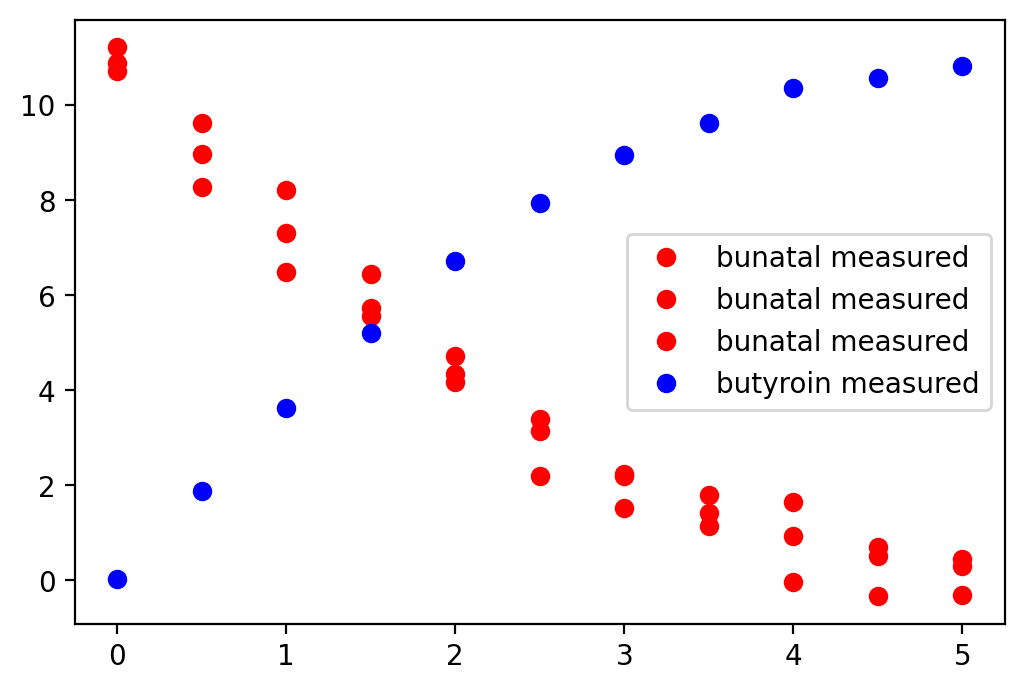

In [1]:
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lmfit

df = pd.read_excel(r"Full Conversion Approach.xlsx", sheet_name = "10mL_viualisation")
plt.rcParams["figure.dpi"] = 200
print(df.head())
print(df.columns)


time = df["time in min"]
substrate = df["3-OH-BA"]
substrate_1 = df["3-OH-BA-forged-1"]
substrate_2 = df["3-OH-BA-forged-2"]
product = df["(S)-3-OH-PAC"]

time_before_feed = time.iloc[:11]
substrate_before_feed = substrate.iloc[:11]
substrate_before_feed_1 = substrate_1.iloc[:11]
substrate_before_feed_2 = substrate_2.iloc[:11]
product_before_feed = product.iloc[:11]

fix, ax = plt.subplots()

ax.plot(time_before_feed, substrate_before_feed, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, substrate_before_feed_1, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, substrate_before_feed_2, label="bunatal measured", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="butyroin measured", color="blue", linestyle="", marker="o")
#ax.plot(time, product2, label="octanediol measured", color="green", linestyle="", marker="o")
ax.legend()


[[10.89125651  8.97781629  7.30626428  5.73190936  4.34999448  3.14620345
   2.18897357  1.4283044   0.92770542  0.51440539  0.30357097]
 [ 0.03110091  1.88371882  3.63186183  5.21201965  6.71397226  7.93279586
   8.95364052  9.62457475 10.35836504 10.57652435 10.81390784]]
[11, 0]
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 22
    # variables        = 2
    chi-square         = 5.72100254
    reduced chi-square = 0.28605013
    Akaike info crit   = -25.6317647
    Bayesian info crit = -23.4496798
[[Variables]]
    kA:  0.50834051 +/- 0.03338610 (6.57%) (init = 2)
    kP:  1.3747e-10 +/- 0.10186993 (74102301001.87%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(kA, kP) = -0.831
None


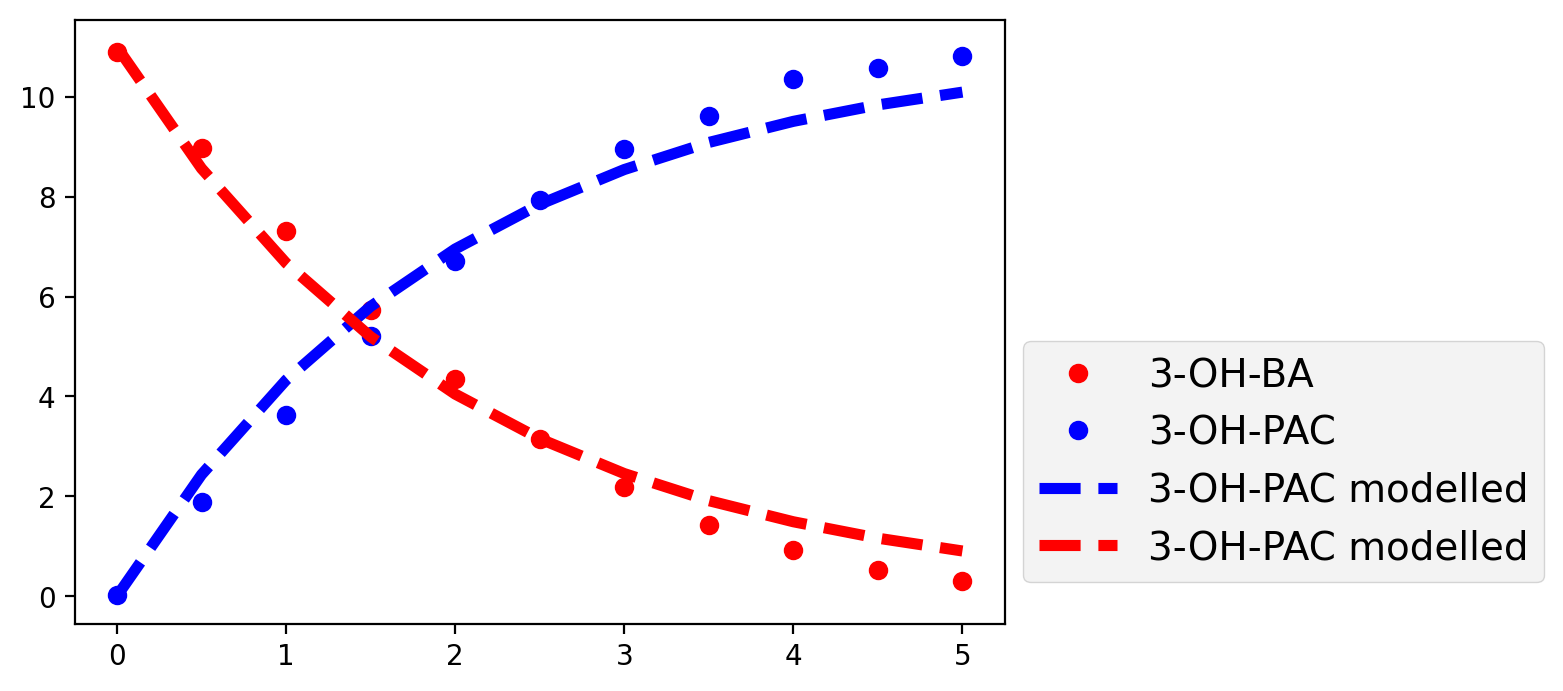

In [2]:
# Definition of DGL system
# A = Initial conditions
# t = time or x-values
# kA = Constant A
# kB = Constant B
data_list = [substrate_before_feed,product_before_feed]

data = np.array(data_list)

print(data)

y0_array = [11, 0]
print(y0_array)

def dadt(kA, kP, A,P, t):
    dadt = -kA*A + kP*P
    return dadt

def dbdt(kA, kP, A, P, t):
        dbdt = kA*A - kP*P 
        return dbdt

def dglsys(init_cond_array, t, kA, kP):
    A = init_cond_array[0]
    P = init_cond_array[1]
    dAdt = dadt(kA, kP, A, P, t)
    dBdt = dbdt(kA, kP, A, P,t)
    dZdt = np.array([dAdt, dBdt])
    return dZdt

#sol = odeint(dglsys, y0_array, time_before_feed, args=(0.50834051, 0.000000000137))
sol = odeint(dglsys, y0_array, time_before_feed, args=(0.5, 0.00005))

params = lmfit.Parameters()
params.add('kA', 2, min=0.00000001, max=3)
params.add('kP', 2, min=0.0000000001, max=3)

def residual(params, time, data_sets):
    kA = params['kA'].value
    kP = params['kP'].value
    
    ymodel=odeint(dglsys, y0_array, time_before_feed, args=(kA, kP))
    substr = data_sets[0]-ymodel[:,0] # array 1
    product = data_sets[1]-ymodel[:,1] # array 2
    result = [substr, product] # result is returned as array
    return np.array(result)

solution = lmfit.minimize(residual, params, args=(np.array(time_before_feed), data))
print(lmfit.report_fit(solution))


fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
ax.plot(time_before_feed, substrate_before_feed, label="3-OH-BA", color="red", linestyle="", marker="o")
ax.plot(time_before_feed, product_before_feed, label="3-OH-PAC", color="blue", linestyle="", marker="o")

ax.plot(time_before_feed, sol[:,1], label="3-OH-PAC modelled", linestyle="--", color="blue")
ax.plot(time_before_feed, sol[:,0], label="3-OH-PAC modelled", linestyle="--", color="red")


ax.legend(loc=9, bbox_to_anchor=(1.3,0.5))
plt.savefig("testfig.svg", format="svg")
plt.show()

In [34]:
# Test with PyMC3
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano

from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint

plt.style.use("seaborn-darkgrid")

data_list = [substrate_before_feed,product_before_feed]

data = np.array(data_list)

y0_array = np.array([11, 0])
y0 = [20]

def dadt(y, t, p):
    dadt = -p[0]*y[0] + p[1]*y[0]
    return dadt

# test data


substrates_1 = np.reshape(np.array(substrate_before_feed_1), (11, 1))
substrates_2 = np.reshape(np.array(substrate_before_feed_2), (11, 1))
substrates = np.reshape(np.array(substrate_before_feed), (11, 1))
time = np.array(time_before_feed)

new_array = np.zeros(shape=(11, 3))

for i in range(11):
    liste = [substrates_1[i][0], substrates_2[i][0], substrates[i][0]]
    #print(liste)
    array = np.array(liste)
    #print(array)
    new_array[i] = array
print(new_array)

matr = np.asmatrix(new_array)
    


#substrates_matrix = [substrates,substrates_1,substrates_2]
#print((substrates_matrix))
#print(substrates_2)



# time array needs the shape (,11) and the data (11,1) 

ode_model = DifferentialEquation(func=dadt, times=time, n_states=1, n_theta=2)


with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    Ka = pm.Uniform("Ka", 0, 1)
    init = pm.Normal("init",11, 1)
    Kb = pm.Uniform("Kb", 0, 0.000000001)
    sigma = pm.Normal("sigma", 0.1)

    ode_solution = ode_model(y0=[11], theta=[Ka, Kb])
    ode_solution1 = ode_model(y0=[11], theta=[Ka, Kb])
    ode_solution2 = ode_model(y0=[11], theta=[Ka, Kb])

    odes = [[ode_solution], [ode_solution1], [ode_solution1]]

    odess = np.array(odes)
    print("odess",odess)


    # man kann die ode solutions slicen
    ode_solution_s = ode_solution[:,0]

    # The ode_solution has a shape of (n_times, n_states)
    # hierarchical modelling 
    # Tensor variablen ansehen

    # Ode solution can be splitted in several likelihoods, however this works
    # murefi???????
    # Array broadcasting: Wenn man als µ einen Vektor reingibt, kann man als observed eine Matrix reingibt

    Y = pm.Normal("Y", mu=odess, sigma=sigma, observed=new_array)

    prior = pm.sample_prior_predictive()
    #trace = pm.sample(2000, tune=1000, cores=1)
    #posterior_predictive = pm.sample_posterior_predictive(trace)

    #data = az.from_pymc3(trace=trace,posterior_predictive=posterior_predictive)


[[11.22015639 10.71334571 10.89125651]
 [ 9.62299969  8.28287693  8.97781629]
 [ 8.21183344  6.48453347  7.30626428]
 [ 6.44131465  5.5606662   5.73190936]
 [ 4.72721043  4.16804691  4.34999448]
 [ 3.38929906  2.19251841  3.14620345]
 [ 2.23433719  1.52268877  2.18897357]
 [ 1.79574685  1.13891025  1.4283044 ]
 [ 1.6440269  -0.04294924  0.92770542]
 [ 0.70749946 -0.32954055  0.51440539]
 [ 0.45923577 -0.29642507  0.30357097]]
odess [[DifferentialEquation{func=<function dadt at 0x0000020DA33F4168>, times=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0), n_states=1, n_theta=2, t0=0}.0]
 [DifferentialEquation{func=<function dadt at 0x0000020DA33F4168>, times=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0), n_states=1, n_theta=2, t0=0}.0]
 [DifferentialEquation{func=<function dadt at 0x0000020DA33F4168>, times=(0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0), n_states=1, n_theta=2, t0=0}.0]]


ValueError: setting an array element with a sequence.

In [27]:
from scipy import stats

N, s = 100, 10 # number of points per series and number of series

x = np.zeros((N,s))

true_center = 1
true_tau = 2

true_thetas = np.repeat(np.array([[0.7]]),s).reshape(1,s) + np.random.normal(0, 0.2, s)
true_taus = stats.halfnorm.rvs(0.1, size=s)

x[0]=0.0

for i in range(1, N):
    x[i] = true_thetas[0] * (x[i-1]) + stats.norm.rvs(true_center, np.sqrt(1/true_tau), s)
with pm.Model() as m_ar:
    
    theta = pm.Normal('theta', 0, 1, shape=s) # The shape here is stating that there is only 1 theta for each series
    tau = pm.HalfNormal('tau', sd=1, shape=s) # The shape here is stating that there is only 1 tau for each series
    
    # AR Process
    η_t = pm.AR1("η_t", k=theta, tau_e=tau, observed=x) # Here we are using the observed data, so it will evaluate for the 100 parameters of each series
    
    #trace = pm.sample()

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.65277488e+00  7.83307521e-01  9.07429550e-01  1.08279330e+00
   2.08201023e+00  1.46635667e+00 -5.55700005e-05  4.12601508e-01
   4.72474907e-01  1.77529352e+00]
 [ 1.64305317e+00  1.84542743e+00  1.89715995e+00  1.83681929e+00
   1.83383322e+00  1.84564542e+00  8.70661965e-01  1.89771735e+00
   6.09737311e-01  2.14179843e+00]
 [ 1.69061793e+00  3.16524237e+00  2.15851267e+00  2.82950229e+00
   1.15147904e+00  2.77797125e+00  2.27591643e+00  4.04954240e+00
   1.55075357e+00  2.50496893e+00]
 [ 2.34088495e+00  4.48834955e+00  2.75419862e+00  2.23141655e+00
   4.64485228e-01  2.86056291e+00  2.35330874e+00  4.07396848e+00
   2.52290079e+00  3.46039202e+00]
 [ 2.45698649e+00  5.25224504e+00  2.53396359e+00  2.33992955e+00
   1.98837419e+00  3.98092685e+00  1.68705419e+00  4.18938715e+00
   3.65021243e+00  2.93428903e+00

In [36]:

ode_model = DifferentialEquation(func=dadt, times=time, n_states=1, n_theta=2)

substrates_list_1 = [0,1,2,3,4,5,6,7,8,9,10]


def dadt(y, t, p):
    dadt = -p[0]*y[0] + p[1]*y[0]
    return dadt

substrates = np.reshape(np.array(substrates), (11, 1))

with pm.Model() as model:
    # Specify prior distributions for soem of our model parameters
    Ka = pm.Uniform("Ka", 0, 1)
    init = pm.Normal("init",11, 1)
    Kb = pm.Uniform("Kb", 0, 0.000000001)
    sigma = pm.Normal("sigma", 0.1)

    ode_solution = ode_model(y0=[11], theta=[Ka, Kb])
    Y = pm.Normal("Y", mu=ode_solution, sigma=sigma, observed=substrates)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000, tune=1000, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

c:\Users\SMalz\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, Kb, init, Ka]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 372 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
